In [19]:
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:

# Load your training dataset
file_path = '../dataset/youtube_spam.csv'
train_data = pd.read_csv(file_path)
train_texts = train_data['CONTENT']
train_labels = train_data['CLASS']

# Display training data size and distribution
print(f'Training Data Size: {len(train_data)}')
print('Training Data Distribution:')
print(train_labels.value_counts())

Training Data Size: 1956
Training Data Distribution:
CLASS
1    1005
0     951
Name: count, dtype: int64


In [16]:
def text_preprocessing(text):
    # Lowercase all sentences
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r'[-+]?[0-9]+', ' ', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    
    # Remove email addresses
    text = re.sub(r'\S*@\S*\s?', ' ', text)
    
    # Remove punctuation and other symbols
    text = re.sub(r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]', ' ', text)

    # Correct duplication of three or more characters in a row (e.g., "yukkk" -> "yuk")
    text = re.sub(r'([a-zA-Z])\1\1+', r'\1', text)
    
    # Remove multiple whitespace
    text = re.sub(r' +', ' ', text)
    
    # Remove leading and trailing whitespace
    text = text.strip()
    
    # Remove non-ASCII characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Tokenize words
    word_tokens = word_tokenize(text)
    
    # Define English stopwords removal
    stop_words = set(stopwords.words('english'))
    clean_words = [word for word in word_tokens if word not in stop_words]
    
    # Join tokens back into a clean string
    clean_words = ' '.join(clean_words)
    
    return clean_words


In [17]:

# Lemmatization function
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Apply preprocessing to the training dataset
train_texts = train_data['CONTENT'].apply(text_preprocessing).apply(lemmatize_text)
train_labels = train_data['CLASS']

# Convert the text data into TF-IDF feature vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train = tfidf_vectorizer.fit_transform(train_texts)



Evaluating with test size: 0.2

Training and Evaluating RandomForest with test size 0.2...
Accuracy: 0.90
Precision: 0.91
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[172   4]
 [ 37 179]]

Training and Evaluating NaiveBayes with test size 0.2...
Accuracy: 0.87
Precision: 0.88
Recall: 0.87
F1 Score: 0.87
Confusion Matrix:
[[158  18]
 [ 32 184]]

Training and Evaluating XGBoost with test size 0.2...
Accuracy: 0.90
Precision: 0.91
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[170   6]
 [ 35 181]]

Training and Evaluating SVM_Linear with test size 0.2...
Accuracy: 0.90
Precision: 0.91
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[168   8]
 [ 31 185]]

Training and Evaluating SVM_RBF with test size 0.2...
Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[167   9]
 [ 32 184]]

Training and Evaluating SVM_Poly with test size 0.2...
Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[152  24]
 [ 17 199]]

Training and Evaluating S

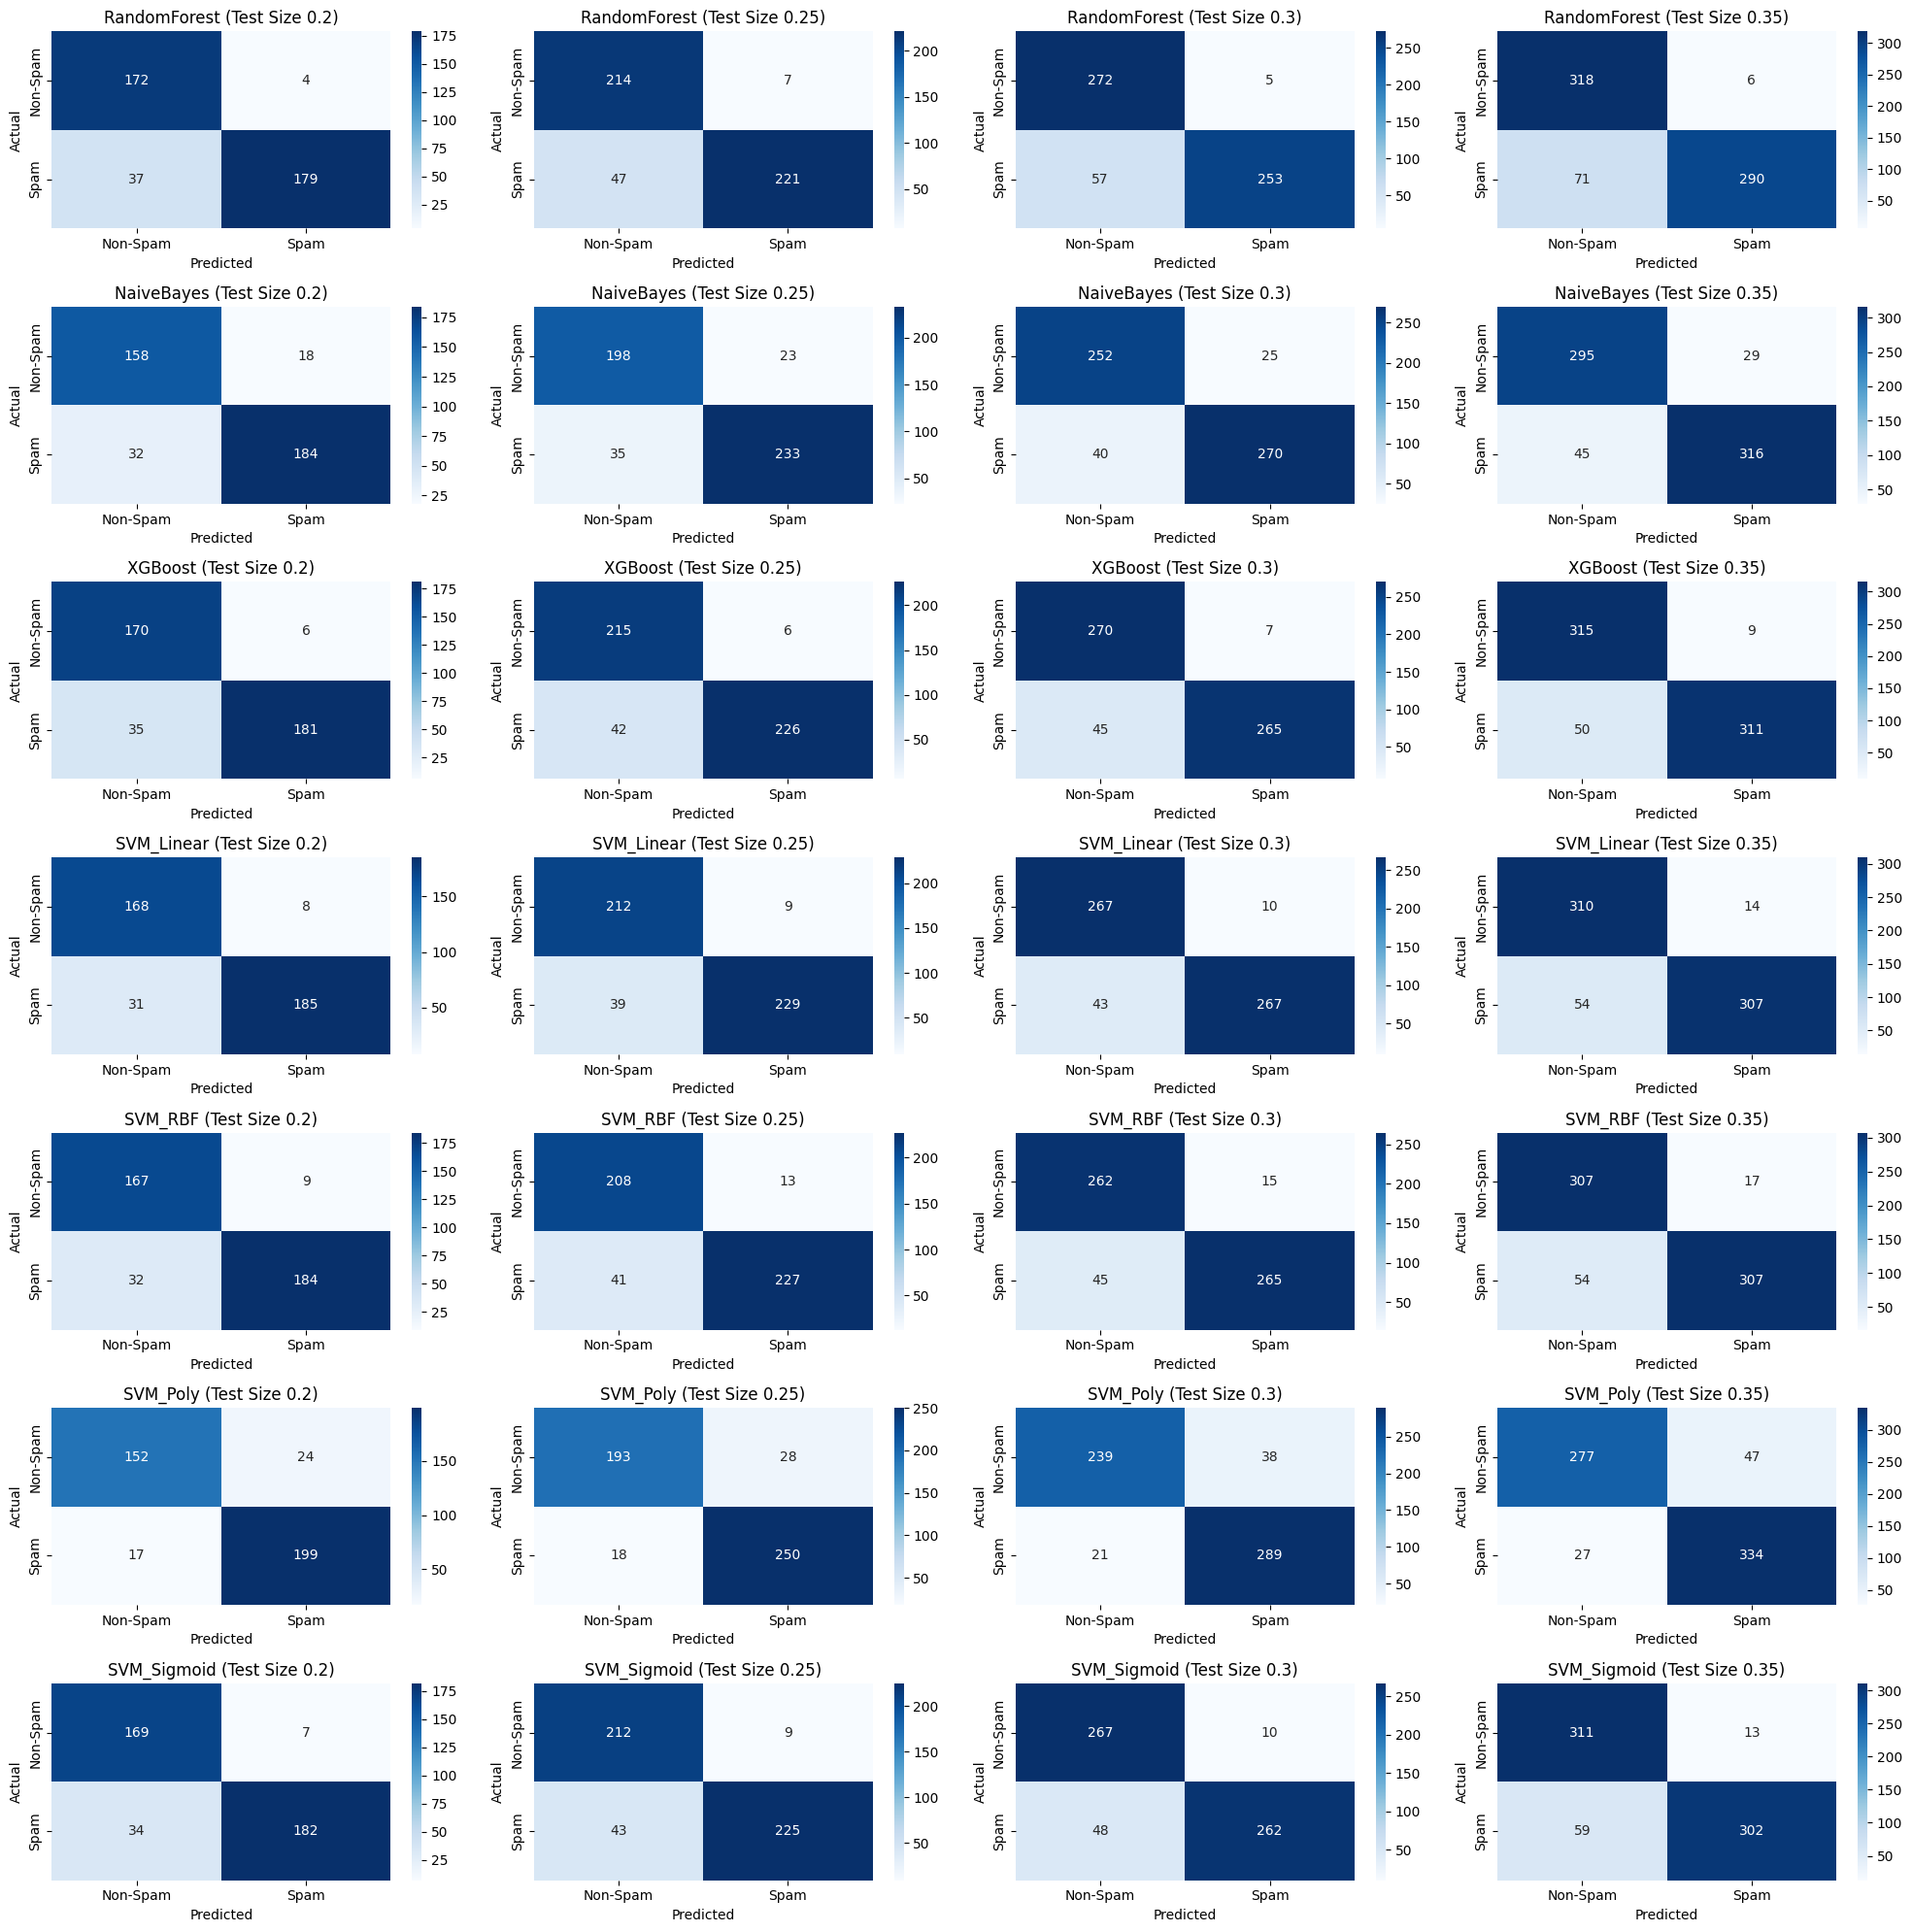

Cross-validation results saved to cross_validation_results.csv


In [25]:

# Define models for training, including SVM with different kernels
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2),
    'NaiveBayes': MultinomialNB(alpha=0.5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=6, learning_rate=0.1),
    'SVM_Linear': SVC(kernel='linear', probability=True, C=1),
    'SVM_RBF': SVC(kernel='rbf', probability=True, C=1, gamma='scale'),
    'SVM_Poly': SVC(kernel='poly', probability=True, C=1, degree=3),
    'SVM_Sigmoid': SVC(kernel='sigmoid', probability=True, C=1)
}

# # Train models and save them
# for model_name, model in models.items():
#     print(f'\nTraining {model_name}...')
#     model.fit(X_train, train_labels)
#     # Save the trained model
#     joblib.dump(model, f'{model_name}_model.pkl')

# # Save the TF-IDF vectorizer
# joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# Cross-validation with predictions for each model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# Train and evaluate each model with different test sizes
test_sizes = [0.2, 0.25, 0.3, 0.35]

fig, axes = plt.subplots(len(models), len(test_sizes), figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# for test_size in test_sizes:
for test_size_idx, test_size in enumerate(test_sizes):
    print(f'\nEvaluating with test size: {test_size}')
    
    # Split the original dataset into different training and test sets
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, train_labels, test_size=test_size, random_state=42)
    
    for model_idx, (model_name, model) in enumerate(models.items()):
    # for model_name, model in models.items():
        print(f'\nTraining and Evaluating {model_name} with test size {test_size}...')
        # Train the model
        model.fit(X_train_split, y_train_split)
        
        # Make predictions
        predictions = model.predict(X_test_split)
        
        # Evaluate the model
        accuracy = accuracy_score(y_test_split, predictions)
        precision = precision_score(y_test_split, predictions, average='weighted')
        recall = recall_score(y_test_split, predictions, average='weighted')
        f1 = f1_score(y_test_split, predictions, average='weighted')
        conf_matrix = confusion_matrix(y_test_split, predictions)
        
        print(f'Accuracy: {accuracy:.2f}')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1 Score: {f1:.2f}')
        print(f'Confusion Matrix:\n{conf_matrix}')

        # # Plot confusion matrix
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'])
        # plt.xlabel('Predicted')
        # plt.ylabel('Actual')
        # plt.title(f'Confusion Matrix for {model_name} (Test Size {test_size})')
        # plt.savefig(f'visualisasi/confusion_matrix_{model_name}_test_size_{test_size}.png')
        # plt.show()
        # Plot confusion matrix in a single figure
        ax = axes[model_idx, test_size_idx]
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'], ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'{model_name} (Test Size {test_size})')
        
        # Save the trained model for each test size
        joblib.dump(model, f'{model_name}_model_test_size_{test_size}.pkl')

plt.tight_layout()
plt.savefig('combined_confusion_matrix_plot.png')
plt.show()

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer_multitest.pkl')

# Save cross-validation results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('cross_validation_results_multitest.csv', index=False)
print('Cross-validation results saved to cross_validation_results.csv')


In [26]:

# Load and preprocess the testing dataset
test_data_path = '../youtube_comments_i6IOiUi6IYY.xlsx'
test_data = pd.read_excel(test_data_path)
test_texts = test_data['Comment'].apply(text_preprocessing).apply(lemmatize_text)

# Load the TF-IDF vectorizer and transform the test data
loaded_vectorizer = joblib.load('tfidf_vectorizer_multitest.pkl')
X_test = loaded_vectorizer.transform(test_texts)

# # Load models and make predictions
# for model_name in models.keys():
#     print(f'\nLoading {model_name} model and making predictions...')
#     loaded_model = joblib.load(f'{model_name}_model.pkl')
#     predictions = loaded_model.predict(X_test)
#     test_data[f'{model_name}_Prediction'] = predictions

# Load models and make predictions
for test_size in test_sizes:
    for model_name in models.keys():
        print(f'\nLoading {model_name} model trained with test size {test_size} and making predictions...')
        loaded_model = joblib.load(f'{model_name}_model_test_size_{test_size}.pkl')
        predictions = loaded_model.predict(X_test)
        test_data[f'{model_name}_Prediction_test_size_{test_size}'] = predictions



Loading RandomForest model trained with test size 0.2 and making predictions...

Loading NaiveBayes model trained with test size 0.2 and making predictions...

Loading XGBoost model trained with test size 0.2 and making predictions...

Loading SVM_Linear model trained with test size 0.2 and making predictions...

Loading SVM_RBF model trained with test size 0.2 and making predictions...

Loading SVM_Poly model trained with test size 0.2 and making predictions...

Loading SVM_Sigmoid model trained with test size 0.2 and making predictions...

Loading RandomForest model trained with test size 0.25 and making predictions...

Loading NaiveBayes model trained with test size 0.25 and making predictions...

Loading XGBoost model trained with test size 0.25 and making predictions...

Loading SVM_Linear model trained with test size 0.25 and making predictions...

Loading SVM_RBF model trained with test size 0.25 and making predictions...

Loading SVM_Poly model trained with test size 0.25 and 

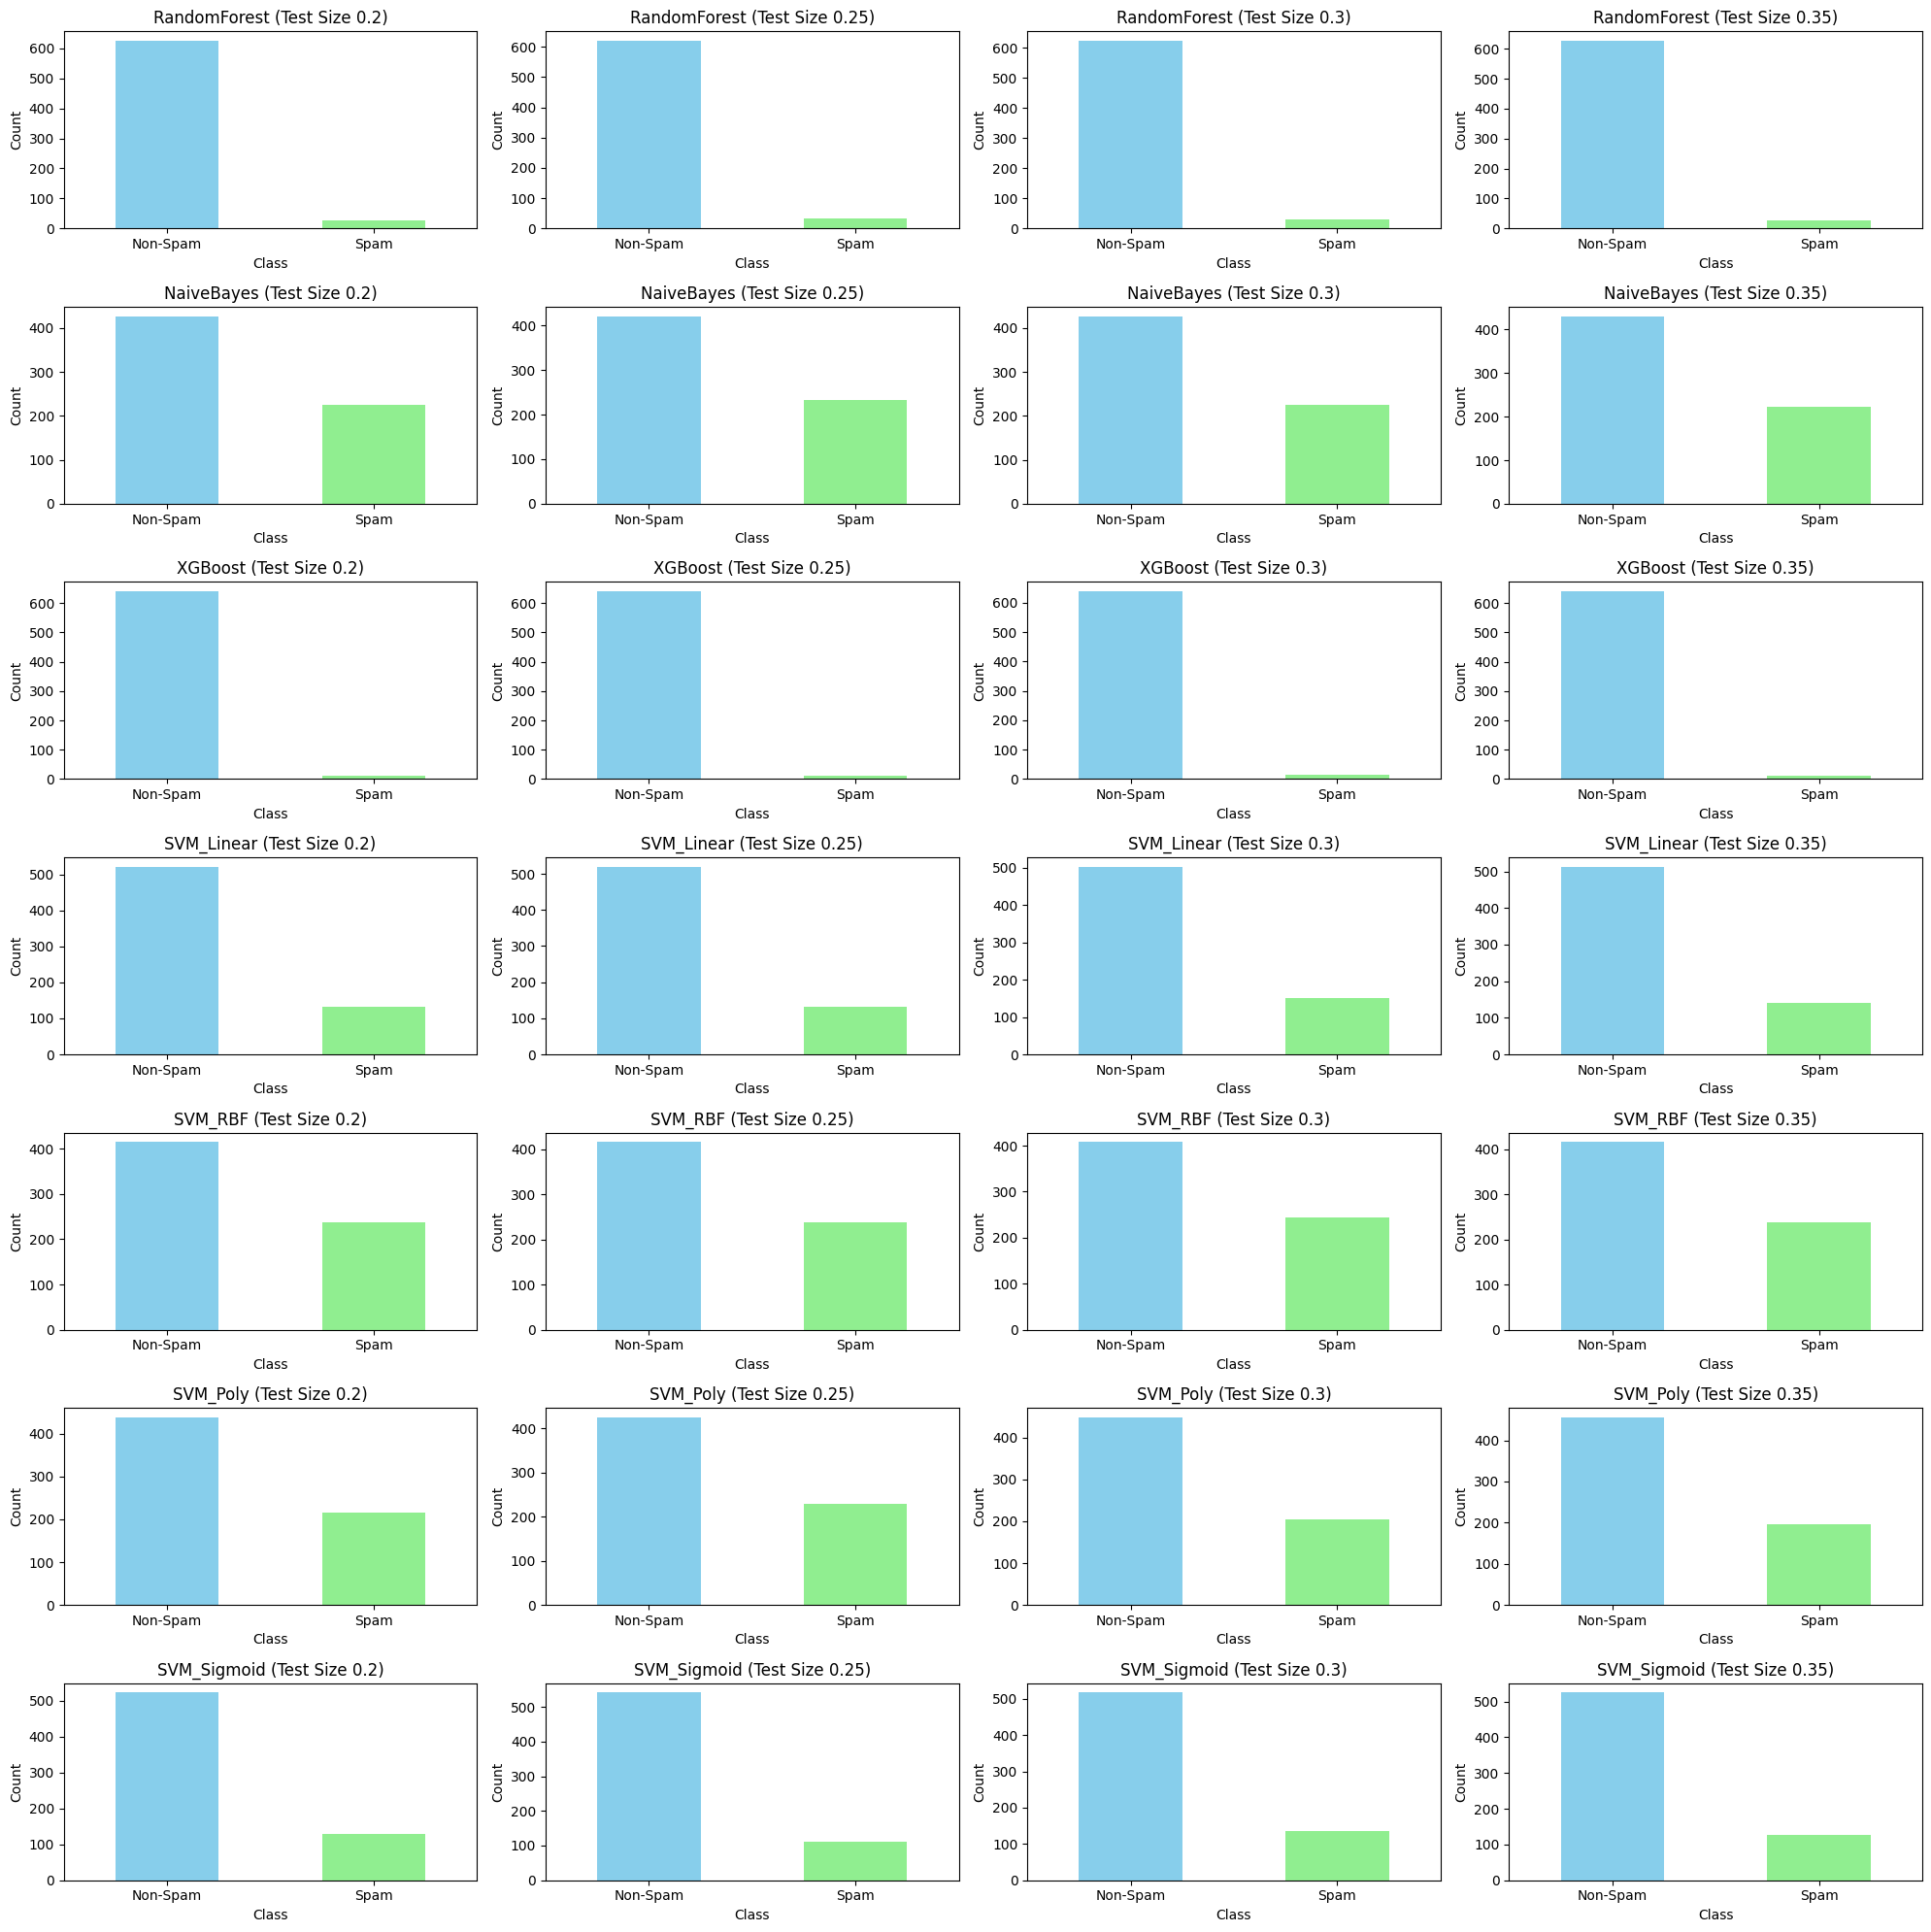

Predictions saved to youtube_comments_predictions.xlsx and youtube_comments_predictions_multitest.csv


In [28]:
# # Visualize the distribution of predictions for each model
# for model_name in models.keys():
#     plt.figure(figsize=(6, 4))
#     test_data[f'{model_name}_Prediction'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen'])
#     plt.xlabel('Class')
#     plt.ylabel('Count')
#     plt.title(f'Distribution of {model_name} Predictions')
#     plt.xticks(rotation=0)
#     plt.show()
# Visualize the distribution of predictions for each model and test size

# for test_size in test_sizes:
#     for model_name in models.keys():
#         plt.figure(figsize=(6, 4))
#         test_data[f'{model_name}_Prediction_test_size_{test_size}'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen'])
#         plt.xlabel('Class')
#         plt.ylabel('Count')
#         plt.title(f'Distribution of {model_name} Predictions (Test Size {test_size})')
#         plt.xticks(rotation=0)
#         plt.savefig(f'predictions_distribution_{model_name}_test_size_{test_size}.png')
#         plt.show()
# Visualize the distribution of predictions for each model and test size

fig, axes = plt.subplots(len(models), len(test_sizes), figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for test_size_idx, test_size in enumerate(test_sizes):
    for model_idx, model_name in enumerate(models.keys()):
        ax = axes[model_idx, test_size_idx]
        test_data[f'{model_name}_Prediction_test_size_{test_size}'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen'], ax=ax)
        ax.set_xlabel('Class')
        ax.set_ylabel('Count')
        ax.set_title(f'{model_name} (Test Size {test_size})')
        ax.set_xticklabels(['Non-Spam', 'Spam'], rotation=0)

plt.tight_layout()
plt.savefig('combined_predictions_distribution.png')
plt.show()

# Save the predictions to an Excel file and CSV file
test_data.to_excel('youtube_comments_predictions_multitest.xlsx', index=False)
test_data.to_csv('youtube_comments_predictions_multitest.csv', index=False)
print('Predictions saved to youtube_comments_predictions.xlsx and youtube_comments_predictions_multitest.csv')

